In [289]:
from os import listdir
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data

In [290]:
listdir("./data/")

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'LR_cv.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv',
 'ss_data.csv',
 'target.csv',
 'us_data.csv',
 'us_data_subset.csv',
 'XGBoost_cv.csv']

Les fichiers application_XXXX.csv contiennent déjà beaucoup d'information _a priori_ pertinentes pour constuire le modèle de classification. Nous pouvons commencer par exploiter cette première source d'information avant de voir ce que les autres fichiers peuvent apporter. (A noter, basé sur l'exemple de Kaggle, le meilleur score obtenu pour le ROC AUC - après _hyperparameters tunning_ est d'environ 0.785 avec lightGBM).

## Application files

In [291]:
application_train = pd.read_csv('./data/application_train.csv')
application = application_train
application_test = pd.read_csv('./data/application_test.csv')

print("Shapes: train {}, test {}".format(application_train.shape, application_test.shape))

Shapes: train (307511, 122), test (48744, 121)


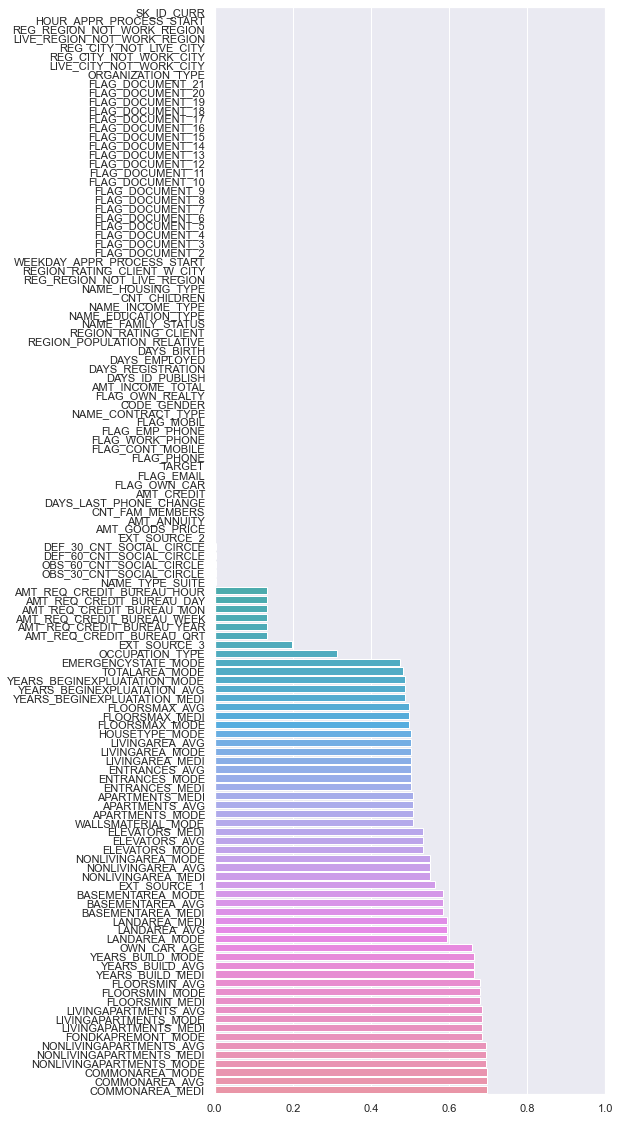

In [292]:
# Check missing values 

nan_ = application.apply(lambda x : np.mean((pd.isnull(x)))).sort_values()

sns.set(rc = {'figure.figsize':(7,20)}, font_scale = 1)
sns.barplot(y=nan_.index, x=nan_)
plt.xlim([0,1]);

Nous allons supprimer les features qui ont plus d'une certaine proportion de valeurs manquantes (disons 40%), mais néanmoins conserver la variable EXT_SOURCE_1 qui semble importante pour la classification d'après les résultats observés sur Kaggle. 

In [293]:
na_threshold = 0.4
cols = list(nan_.index[nan_<na_threshold])
cols.append('EXT_SOURCE_1') # Let's keep ext_source_1 (seems important in other places)
application = application[cols].copy()

### Exploration détaillée des colonnes

In [294]:
from collections import Counter
print(' ====> Columns types : {}'.format(Counter(application.dtypes))) 

print(' ====> Values contained in (Int) columns : ')
counts = {}
for c in application.columns[application.dtypes == 'int64']:
    counts[c] = len(set(application[c]))
    print('Columns : {} => unique values : {}'.format(c, counts[c]))

 ====> Columns types : Counter({dtype('int64'): 41, dtype('float64'): 21, dtype('O'): 12})
 ====> Values contained in (Int) columns : 
Columns : SK_ID_CURR => unique values : 307511
Columns : HOUR_APPR_PROCESS_START => unique values : 24
Columns : REG_REGION_NOT_WORK_REGION => unique values : 2
Columns : LIVE_REGION_NOT_WORK_REGION => unique values : 2
Columns : REG_CITY_NOT_LIVE_CITY => unique values : 2
Columns : REG_CITY_NOT_WORK_CITY => unique values : 2
Columns : LIVE_CITY_NOT_WORK_CITY => unique values : 2
Columns : FLAG_DOCUMENT_21 => unique values : 2
Columns : FLAG_DOCUMENT_20 => unique values : 2
Columns : FLAG_DOCUMENT_19 => unique values : 2
Columns : FLAG_DOCUMENT_18 => unique values : 2
Columns : FLAG_DOCUMENT_17 => unique values : 2
Columns : FLAG_DOCUMENT_16 => unique values : 2
Columns : FLAG_DOCUMENT_15 => unique values : 2
Columns : FLAG_DOCUMENT_14 => unique values : 2
Columns : FLAG_DOCUMENT_13 => unique values : 2
Columns : FLAG_DOCUMENT_12 => unique values : 2
Co

All columns with two values are flags (i.e. 0/1), unrelated to paiement risk _a priori_. 

In [295]:
# Remove FLAGs columns (which are a priori useless for prediction, e.g. whether the phone number is given or not...)
other_flags = ['REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY',]
cols = [c for c in cols if ('FLAG' not in c) and (c not in other_flags)]
application = application[cols].copy()

Pour les autres :

In [296]:
print(' ====> Values contained in (Int) columns : ')
counts = {}
for c in application.columns[application.dtypes == 'int64']:
    counts[c] = len(set(application[c]))
    print('Columns : {} => unique values : {}'.format(c, counts[c]))

 ====> Values contained in (Int) columns : 
Columns : SK_ID_CURR => unique values : 307511
Columns : HOUR_APPR_PROCESS_START => unique values : 24
Columns : REGION_RATING_CLIENT_W_CITY => unique values : 3
Columns : CNT_CHILDREN => unique values : 15
Columns : REGION_RATING_CLIENT => unique values : 3
Columns : DAYS_BIRTH => unique values : 17460
Columns : DAYS_EMPLOYED => unique values : 12574
Columns : DAYS_ID_PUBLISH => unique values : 6168
Columns : TARGET => unique values : 2


Among those : 
    
+ REGION_RATING_CLIENT_W_CITY : Rating of the region (1,2,3) - note, there is one '-1' to be removed.                                        OK 
+ REGION_RATING_CLIENT : Rating of the region (1,2,3)                                                                                        OK
+ HOUR_APPR_PROCESS_START : approx. hour at which client apply...                                                                            nOK
+ CNT_CHILDREN : # of children                                                                                                               OK
+ DAYS_BIRTH : client age at time of application (in days)                                                                                   OK
+ DAYS_EMPLOYED : How many days before the application the person started current position                                                   OK
+ DAYS_ID_PUBLISH : How many days before the application did client change the identity document with which he applied for the loan (?!=     OK?

In [297]:
# Kick the -1 from REGION_RATING
application = application[application.REGION_RATING_CLIENT_W_CITY  != -1].copy()

# Remove HOUR_APPR_PROCESS_START columns
application.drop(columns=['HOUR_APPR_PROCESS_START'], inplace = True)

In [298]:
print(' ====> Values contained in (Object) columns : ')
counts = {}
for c in application.columns[application.dtypes == 'O']:
    counts[c] = len(set(application[c]))
    print('Columns : {} => unique values : {}'.format(c, counts[c]))

 ====> Values contained in (Object) columns : 
Columns : ORGANIZATION_TYPE => unique values : 58
Columns : WEEKDAY_APPR_PROCESS_START => unique values : 7
Columns : NAME_HOUSING_TYPE => unique values : 6
Columns : NAME_INCOME_TYPE => unique values : 8
Columns : NAME_EDUCATION_TYPE => unique values : 5
Columns : NAME_FAMILY_STATUS => unique values : 6
Columns : CODE_GENDER => unique values : 3
Columns : NAME_CONTRACT_TYPE => unique values : 2
Columns : NAME_TYPE_SUITE => unique values : 8
Columns : OCCUPATION_TYPE => unique values : 19


Among those variables;

+ ORGANIZATION_TYPE : type of organization where client works                OK
+ WEEKDAY_APPR_PROCESS_START : on which day did the client apply...         nOK
+ NAME_FAMILY_STATUS : married, widow, separated, etc.                       OK
+ NAME_INCOME_TYPE : working, student, businessman, pensioner, ...           OK
+ NAME_EDUCATION_TYPE : Level of highest education                           OK
+ NAME_HOUSING_TYPE : Housing situation (house/apt, rented, parents...)      OK
+ CODE_GENDER : gender (M, F, XNA ? to remove)                               OK
+ NAME_CONTRACT_TYPE : cash or revolving ? don't understand                  OK
+ NAME_TYPE_SUITE : Who was accompanying the client when he applies          OK
+ OCCUPATION_TYPE : Kind of occupation client have (at work)                 OK

All those should be converted as dummies (GENDER can be directly factorize())

In [299]:
# Just kick the XNA from GENDER (nothing against no gender people but only three so uninformative)
application = application[application.CODE_GENDER != 'XNA'].copy()

# Remove WEEKDAY_APPR_PROCESS_START columns
application.drop(columns=['WEEKDAY_APPR_PROCESS_START'], inplace = True)

In [300]:
print(' ====> Float columns : ')
for c in application.columns[application.dtypes == 'float64']:
    print('Columns : {} '.format(c))

 ====> Float columns : 
Columns : REGION_POPULATION_RELATIVE 
Columns : DAYS_REGISTRATION 
Columns : AMT_INCOME_TOTAL 
Columns : AMT_CREDIT 
Columns : DAYS_LAST_PHONE_CHANGE 
Columns : CNT_FAM_MEMBERS 
Columns : AMT_ANNUITY 
Columns : AMT_GOODS_PRICE 
Columns : EXT_SOURCE_2 
Columns : DEF_30_CNT_SOCIAL_CIRCLE 
Columns : DEF_60_CNT_SOCIAL_CIRCLE 
Columns : OBS_60_CNT_SOCIAL_CIRCLE 
Columns : OBS_30_CNT_SOCIAL_CIRCLE 
Columns : AMT_REQ_CREDIT_BUREAU_HOUR 
Columns : AMT_REQ_CREDIT_BUREAU_DAY 
Columns : AMT_REQ_CREDIT_BUREAU_MON 
Columns : AMT_REQ_CREDIT_BUREAU_WEEK 
Columns : AMT_REQ_CREDIT_BUREAU_YEAR 
Columns : AMT_REQ_CREDIT_BUREAU_QRT 
Columns : EXT_SOURCE_3 
Columns : EXT_SOURCE_1 


Variables:

+ REGION_POPULATION_RELATIVE : Normalized population of region where client lives                                                OK
+ DAYS_REGISTRATION : How many days before the application did client change his registration                                    nOK
+ AMT_INCOME_TOTAL : Income of the client                                                                                        OK
+ AMT_CREDIT : Credit amount of the loan                                                                                         OK
+ DAYS_LAST_PHONE_CHANGE : How many days before application did client change phone                                              nOK
+ CNT_FAM_MEMBERS : How many family members client have                                                                          OK
+ AMT_ANNUITY : Loan annuity                                                                                                     OK
+ AMT_GOODS_PRICE : For consumer loans it is the price of the goods for which the loan is given                                  OK
+ EXT_SOURCE_2/3 : Normalized score from external sources                                                                        OK
+ DEF_30/60_CNT_SOCIAL_CIRCLE : How many observation of client's social surroundings defaulted on 30/60 (days past due) DPD      OK
+ OBS_30/60_CNT_SOCIAL_CIRCLE : How many observation of client's social surroundings with observable 30 DPD default              OK
+ AMT_REQ_CREDIT_BUREAU_XXXX : Number of enquiries to Credit Bureau about the client one XXX before application                  OK

In [301]:
# Remove WEEKDAY_APPR_PROCESS_START columns
application.drop(columns=['DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE'], inplace = True)

### Get dummies

In [302]:
# Factorize Gender Code
application.CODE_GENDER, gender_factors = pd.factorize(application.CODE_GENDER)

# get dummies for categorical variables
cat_cols = [c for c in application.columns if application[c].dtype == 'object']
application_dummies = pd.get_dummies(application, columns = cat_cols)

# Some correction and features computation
application_dummies['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

# Some simple new features (percentages)
## % of days employed over lifetime
application_dummies['DAYS_EMPLOYED_PERC'] = application_dummies['DAYS_EMPLOYED'] / application_dummies['DAYS_BIRTH']

## Customer incomes relative to total credit amount
application_dummies['INCOME_CREDIT_PERC'] = application_dummies['AMT_INCOME_TOTAL'] / application_dummies['AMT_CREDIT']

## Customer incomes scaled by family size
application_dummies['INCOME_PER_PERSON'] = application_dummies['AMT_INCOME_TOTAL'] / application_dummies['CNT_FAM_MEMBERS']

## Loan annuity relative to customer incomes
application_dummies['ANNUITY_INCOME_PERC'] = application_dummies['AMT_ANNUITY'] / application_dummies['AMT_INCOME_TOTAL']

## Annuities relative to total credit amount
application_dummies['PAYMENT_RATE'] = application_dummies['AMT_ANNUITY'] / application_dummies['AMT_CREDIT']

In [303]:
application.columns

Index(['SK_ID_CURR', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT_W_CITY',
       'NAME_HOUSING_TYPE', 'CNT_CHILDREN', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'REGION_RATING_CLIENT',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'AMT_INCOME_TOTAL', 'CODE_GENDER',
       'NAME_CONTRACT_TYPE', 'TARGET', 'AMT_CREDIT', 'CNT_FAM_MEMBERS',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'NAME_TYPE_SUITE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'EXT_SOURCE_3', 'OCCUPATION_TYPE',
       'EXT_SOURCE_1'],
      dtype='object')

Table de données finale contient 143 variables, pour env. 300k clients.

# Analyse

Nous ici comparer deux classifieurs; (i) une regression logistique (avec penalité _l1_ ou _l2_, regression Lasso/Ridge), (ii) un classifieur basé sur les ensembles d'apprenants faibles - XGBoost. 

Il convient de noter que le jeu de données est assez fortement déséquilibré (8% de positifs), ainsi l'utilisation d'une méthode pour ré-équilibrer les données d'entrainement peut être souhaitable. Il serait possible d'utiliser une méthode permettant de sur-échantilloner la classe minoritaire (e.g., SMOTE) afin de créer des échantillons synthétiques proches des données existantes sans perte de données. 

Cependant, nous considérerons ici une méthode de sous-échantillonage de la classe majoritaire, et ce pour deux raisons: (i) le jeu de données est suffisament grand (>300k) pour sous-échantillonner la classe majoritaire tout en conservant suffisament de puissance statistique (i.e. en sous-échantillonant la classe majoriatire, le jeu de données final sera de taille approx. de 50k individus avec un ratio 1:1)., (ii) les variables considérées sont - pour une bonne partie - de type catégoriel (sous forme de 0/1 après l'hot-encoding), la création de nouveau individus par interpolation (e.g., via K-means de SMOTE) aboutirait à des valeurs réelles (dans [0, 1]) n'ayant pas d'interprétation claire _a priori_. 

La fonction "under_sampling()" définie dans le bloc suivant servira à réaliser ce sous-échantillonage. 

In [62]:
import time
from contextlib import contextmanager
import itertools
import re

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, fbeta_score, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from xgboost import XGBClassifier


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
def under_sampling(X, y, factor = None):
    under_represented_idx = min(Counter(y), key=Counter(y).get) 
    if factor is None:
        cnt_under_represented = sum( y==under_represented_idx )
    else:
        prop = factor * (sum( y==under_represented_idx ) / len(y))
        cnt_under_represented = int( len(y) * prop)
        
    nidx = np.random.choice( np.where(y == 1-under_represented_idx)[0], size = cnt_under_represented, replace = False )
    nidx_all = np.concatenate( [np.where(y==under_represented_idx)[0], nidx] )

    return X.iloc[nidx_all,:], y.iloc[nidx_all]

# Fonction permettant de construire la liste de toutes les combinaisons possibles de paramètres
# à partir d'un dictionnaire de listes des valeurs possibles par parametre.
def expand_param_grid(params):
    keys, values = zip(*params.items())
    return [dict(zip(keys, v)) for v in itertools.product(*values)]

In [64]:
# Preprocess dataset
app = application_dummies.set_index('SK_ID_CURR')
# Récupération des valeurs cibles pour la classif.
target = app.TARGET

# Correction d'un problème d'encodage sur certains noms de colonnes
app = app.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
app.drop(columns = ['TARGET'], inplace = True)

# Standardisation des données
ss = preprocessing.StandardScaler()
ss.fit(app)
app_ss = pd.DataFrame(ss.transform(app), columns = app.columns)

app_ss['SK_ID_CURR'] = app.index

In [65]:
import pickle

# Les valeurs utilisées (ou plutôt l'object StandardScaler()) pour la standardisation sont sauvegardées sous forme sérialisées
# de manière à pouvoir être réutiliser dans l'API
with open('standard_scaler.pkl', 'wb') as outp:
    pickle.dump(ss, outp, pickle.HIGHEST_PROTOCOL)

In [66]:
# Save data 
app_to_save = app.reset_index(level=0)
app_to_save['TARGET'] = list(target)

# La table de données est largement sous-échantillonnées pour l'API en raison de contraintes de taille (à la fois sur GitHub et sur Heroku)
app_to_save_sub = app_to_save.sample(frac=0.1)

app_to_save.to_csv('./data/us_data.csv', index = False)
app_to_save_sub.to_csv('./data/us_data_subset.csv', index = False)

## Logistic regression

Il n'est pas possible de considérer les valeurs manquantes dans le cas de la régression logistique, or supprimer les individus concernés aboutirait à une réduction de près de 68% du jeu de données. Au lieu de cela, nous considérons donc un simple Imputer, qui utilisera les valeurs moyennes (zéros dans le cas présent en raison de standardisation) pour compléter les valeurs manquantes. 

In [143]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
app_ss_imputed = pd.DataFrame(SimpleImputer().fit_transform(app_ss), columns = app_ss.columns)

In [144]:
# Fonction permettant de lancer un ensemble de fit sur un jeu de données avec différents set de paramètres
def run_LR(X_, y_, params):
    permutations_dicts = expand_param_grid(params)
    
    models = []
    params = []
    fit_time = []
    
    for prms in permutations_dicts:
        params.append(prms)
        with timer('Run models with params : {}'.format(prms)):
            t0_ = time.time()
            models.append(LogisticRegression(**prms).fit(X_, y_))
            fit_time.append( time.time()-t0_ )

    return models, params, fit_time

In [145]:
# Séparation du jeu de données en données d'entrainement, et données de validation
X_train, X_valid, y_train, y_valid = train_test_split(app_ss_imputed.drop(columns=['SK_ID_CURR']), target, test_size=0.3)

# ############ micro test ##########################
# rind = np.random.choice(np.arange(0, app_ss_imputed.shape[0]), replace = False, size = 10000)
# X_train, X_valid, y_train, y_valid = train_test_split(app_ss_imputed.drop(columns=['SK_ID_CURR']).iloc[rind,:], target.iloc[rind], test_size=0.3)
# ##################################################

# Définition des différentes stratégies pour 're-balancer' les données ou non
balanced_strategies = ['unbalanced', 'unbalance_test_only' ,'balanced']

# Définition des seuils utilisés pour le calcul du F-Score ainsi que de la valeur beta
thresholds = np.arange(0.05, 1, 0.05)
beta = 2

# Définitiond des hyper-parametres explorés.
# A noter : nous testerons également de pondérés les classes (ou non) de manière à considérer la nature non-balancée des données.
log_reg_params = {'penalty': ['l1', 'l2'],
                  'C': np.logspace(-6, 2, 7),
                  'class_weight' : [None, 'balanced'],
                  'max_iter' : [100, 200],
                  'solver' : ['saga']}

# Définition des K-folds pour la validation croisée.
folds = {}
kfolds_ = KFold(n_splits= 5, shuffle=True)

for bs in balanced_strategies:
    folds[bs] = []
    for k, (train_idx, test_idx) in enumerate(kfolds_.split(X_train, y_train)):
        folds[bs].append((train_idx, test_idx))

In [ ]:
results = []
    
for bs in balanced_strategies:
    
    # Loop over methods & parameters
    
    scores = np.empty( 6 )
    pred_times = np.empty( 3 )
        
    for f in range(len(folds[bs])):
        
        # Split data into train/test according to K-folds defined earlier
        if bs == 'unbalanced':
            X_train_, y_train_ = X_train.iloc[folds[bs][f][0],:], y_train.iloc[folds[bs][f][0]] 
            X_test_, y_test_ = X_train.iloc[folds[bs][f][1],:], y_train.iloc[folds[bs][f][1]]
        elif bs == 'unbalance_test_only':
            X_train_, y_train_ = under_sampling(X_train.iloc[folds[bs][f][0],:], y_train.iloc[folds[bs][f][0]], 2)
            X_test_, y_test_ = X_train.iloc[folds[bs][f][1],:], y_train.iloc[folds[bs][f][1]]
        else: # Balanced
            X_train_, y_train_ = under_sampling(X_train.iloc[folds[bs][f][0],:], y_train.iloc[folds[bs][f][0]], 2)
            X_test_, y_test_ = under_sampling(X_train.iloc[folds[bs][f][1],:], y_train.iloc[folds[bs][f][1]], 2)
            
        with timer('Run models for fold k : {}'.format(f+1)):
            models, params, fit_time = run_LR(X_train_, y_train_, log_reg_params)
           
            # Compute test statistics over models
            for idx in range(len(models)):
                
                with timer("Scores (ROCAUC & Fbeta) computation"):

                    t0_ = time.time()
                    pp_train = models[idx].predict_proba(X_train_)[:,1]
                    pred_times[0] = time.time() - t0_
                    
                    t0_ = time.time()
                    pp_test = models[idx].predict_proba(X_test_)[:,1]
                    pred_times[1] = time.time() - t0_
                    
                    t0_ = time.time()                    
                    pp_valid = models[idx].predict_proba(X_valid)[:,1]
                    pred_times[2] = time.time() - t0_
                    
                    # Compute ROC-AUC scores
                    scores[:3] = [roc_auc_score(y_train_, pp_train),
                                    roc_auc_score(y_test_, pp_test),
                                    roc_auc_score(y_valid, pp_valid)]

                    # Compute F-scores according to threshold
                    
                    fb_scores = np.empty( (len(thresholds), 3 ) )

                    for i, t in enumerate(thresholds) :
                        yp_train = (pp_train > t).astype('int')
                        yp_test = (pp_test > t).astype('int')
                        yp_valid = (pp_valid > t).astype('int')

                        fb_scores[i, :] = [   fbeta_score(y_train_, yp_train, beta = beta),
                                              fbeta_score(y_test_, yp_test, beta = beta),
                                              fbeta_score(y_valid, yp_valid, beta = beta) ]

                    scores[3:6] = np.apply_along_axis(lambda x: max(x), 0, fb_scores)
                    
                    results.append( [idx, bs, f+1, *scores, fit_time[idx], *pred_times] )



In [149]:
r = pd.DataFrame(results, columns= ['params', 'balance', 'fold',  'ROCAUC_train','ROCAUC_test','ROCAUC_valid', 'best_fb_train', 'best_fb_test', 'best_fb_valid',
                                    'fit_time', 'pred_time_train', 'pred_time_test', 'pred_time_valid']).\
    groupby(['params', 'balance']).agg([np.mean, np.std])

r.columns = ['_'.join(col).strip() for col in r.columns.values]
r.reset_index(inplace=True)

expanded_lr_params = expand_param_grid(log_reg_params)
r.params = r.params.apply(lambda x : expanded_lr_params[x])

# r.to_csv('./data/LR_cv.csv')

## XGBoost

In [158]:
# Fonction permettant de lancer un ensemble de fit sur un jeu de données avec différents set de paramètres
def run_XGBoost(X_, y_, params):
    permutations_dicts = expand_param_grid(params)
    
    models = []
    params = []
    fit_time = []
    
    for prms in permutations_dicts:
        params.append(prms)
        with timer('Run models with params : {}'.format(prms)):
            t0_ = time.time()
            models.append(XGBClassifier(eval_metric=roc_auc_score, nthread=8, **prms).fit(X_, y_))
            fit_time.append( time.time() - t0_ )

    return models, params, fit_time

In [162]:
# Split training and validation
X_train, X_valid, y_train, y_valid = train_test_split(app_ss.drop(columns=['SK_ID_CURR']), target, test_size=0.3)

# ############ micro test ##########################
# rind = np.random.choice(np.arange(0, app_ss.shape[0]), replace = False, size = 150000)
# X_train, X_valid, y_train, y_valid = train_test_split(app_ss.drop(columns=['SK_ID_CURR']).iloc[rind,:], target.iloc[rind], test_size=0.3)
# ##################################################

balanced_strategies = ['unbalanced', 'unbalance_test_only' ,'balanced']

thresholds = np.arange(0.05, 1, 0.05)
beta = 2

XGB_params = {'learning_rate': [0.01, 0.025],
                      'max_depth': [2, 3, 5,],
                      'min_child_weight': [1,3,5],
                      'subsample': [0.5, 0.7],
                      'colsample_bytree': [0.5, 0.7],
                      'n_estimators': [500]}

folds = {}
kfolds_ = KFold(n_splits= 5, shuffle=True)

for bs in balanced_strategies:
    folds[bs] = []
    for k, (train_idx, test_idx) in enumerate(kfolds_.split(X_train, y_train)):
        folds[bs].append((train_idx, test_idx))

In [ ]:
results = []

multithreads_time = time.time()

for bs in balanced_strategies:
    
    # Loop over methods & parameters
    
    scores = np.empty( 6 )
    pred_times = np.empty( 3 )
    
    for f in range(len(folds[bs])):
        if bs == 'unbalanced':
            X_train_, y_train_ = X_train.iloc[folds[bs][f][0],:], y_train.iloc[folds[bs][f][0]] 
            X_test_, y_test_ = X_train.iloc[folds[bs][f][1],:], y_train.iloc[folds[bs][f][1]]
        elif bs == 'unbalance_test_only':
            X_train_, y_train_ = under_sampling(X_train.iloc[folds[bs][f][0],:], y_train.iloc[folds[bs][f][0]], 2)
            X_test_, y_test_ = X_train.iloc[folds[bs][f][1],:], y_train.iloc[folds[bs][f][1]]
        else: # Balanced
            X_train_, y_train_ = under_sampling(X_train.iloc[folds[bs][f][0],:], y_train.iloc[folds[bs][f][0]], 2)
            X_test_, y_test_ = under_sampling(X_train.iloc[folds[bs][f][1],:], y_train.iloc[folds[bs][f][1]], 2)
            
        with timer('Run models for fold k : {}'.format(f+1)):
            models, params, fit_time = run_XGBoost(X_train_, y_train_, XGB_params)
           
            for idx in range(len(models)):
                
                with timer("Scores (ROCAUC & Fbeta) computation"):
                    
                    t0_ = time.time()
                    pp_train = models[idx].predict_proba(X_train_)[:,1]
                    pred_times[0] = time.time() - t0_
                    
                    t0_ = time.time()
                    pp_test = models[idx].predict_proba(X_test_)[:,1]
                    pred_times[1] = time.time() - t0_
                    
                    t0_ = time.time()
                    pp_valid = models[idx].predict_proba(X_valid)[:,1]
                    pred_times[2] = time.time() - t0_
                    
                    scores[:3] = [roc_auc_score(y_train_, pp_train),
                                    roc_auc_score(y_test_, pp_test),
                                    roc_auc_score(y_valid, pp_valid)]

                    fb_scores = np.empty( (len(thresholds), 3 ) )

                    for i, t in enumerate(thresholds) :
                        yp_train = (pp_train > t).astype('int')
                        yp_test = (pp_test > t).astype('int')
                        yp_valid = (pp_valid > t).astype('int')

                        fb_scores[i, :] = [   fbeta_score(y_train_, yp_train, beta = beta),
                                              fbeta_score(y_test_, yp_test, beta = beta),
                                              fbeta_score(y_valid, yp_valid, beta = beta) ]

                    scores[3:6] = np.apply_along_axis(lambda x: max(x), 0, fb_scores)
                    
                    results.append( [idx, bs, f+1, *scores, fit_time, *pred_times] )

print("Total time : {}".format(time.time()-multithreads_time))

In [164]:
r = pd.DataFrame(results, columns= ['params', 'balance', 'fold',  'ROCAUC_train','ROCAUC_test','ROCAUC_valid', 'best_fb_train', 'best_fb_test', 'best_fb_valid',
                                    'fit_time', 'pred_time_train', 'pred_time_test', 'pred_time_valid']).\
    groupby(['params', 'balance']).agg([np.mean, np.std])

r.columns = ['_'.join(col).strip() for col in r.columns.values]
r.reset_index(inplace=True)

exp_XGBoost_params = expand_param_grid(XGB_params)
r.params = r.params.apply(lambda x : exp_XGBoost_params[x])

r.to_csv('./data/XGBoost_cv.csv')

## Concaténer résultats

In [175]:
r_xgb = pd.read_csv('./data/XGBoost_cv.csv')
r_lr = pd.read_csv('./data/LR_cv.csv')

r_xgb.insert(1, "model", 'XGBoost')
r_lr.insert(1, "model", 'LR')

r = pd.concat( [r_xgb, r_lr] ).reset_index(drop=True).drop(columns = ['Unnamed: 0'])

(0.4, 0.45)

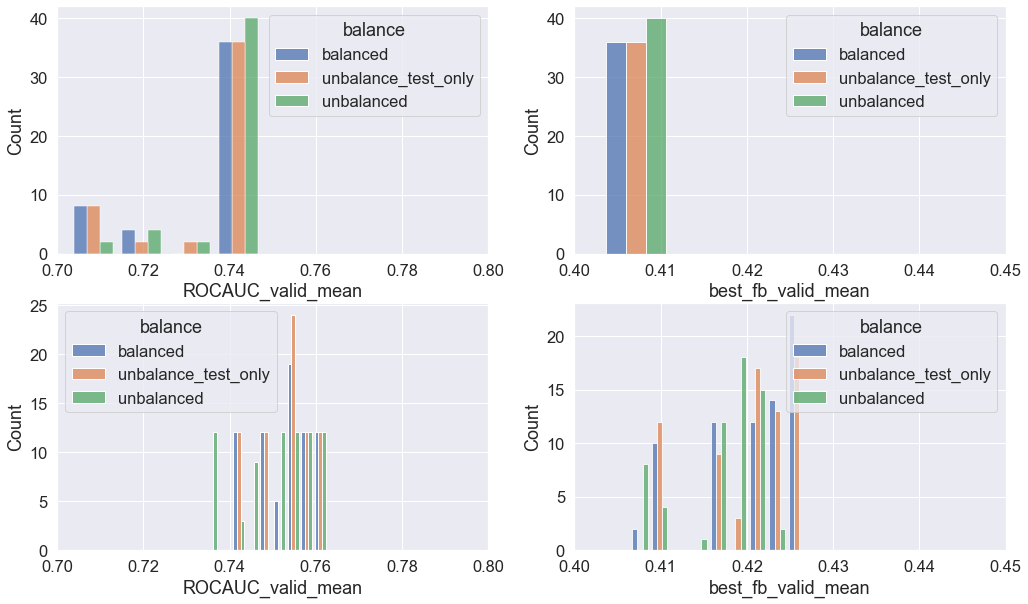

In [207]:
# Check distribution of scores

sns.set(rc = {'figure.figsize':(17,10)}, font_scale = 1.5)
fig, ax = plt.subplots(2,2)

# LR
sns.histplot(x = 'ROCAUC_valid_mean', hue = 'balance', data = r[r.model=='LR'], ax = ax[0,0], multiple="dodge", shrink=0.8)
ax[0,0].set_xlim([0.7, 0.8])

sns.histplot(x = 'best_fb_valid_mean', hue = 'balance', data = r[r.model=='LR'], ax = ax[0,1], multiple="dodge", shrink=0.8)
ax[0,1].set_xlim([0.4, 0.45])

# XGBoost
sns.histplot(x = 'ROCAUC_valid_mean', hue = 'balance', data = r[r.model=='XGBoost'], ax = ax[1,0], multiple="dodge", shrink=0.8)
ax[1,0].set_xlim([0.7, 0.8])

sns.histplot(x = 'best_fb_valid_mean', hue = 'balance', data = r[r.model=='XGBoost'], ax = ax[1,1], multiple="dodge", shrink=0.8)
ax[1,1].set_xlim([0.4, 0.45])


XGBoost est légérement meilleur que la reg. logistique pour les deux métriques d'évaluation. 

In [212]:
r[r.model == 'XGBoost'].sort_values('best_fb_valid_mean', ascending = False).iloc[:10,:]

,model,params,balance,fold_mean,fold_std,ROCAUC_train_mean,ROCAUC_train_std,ROCAUC_test_mean,ROCAUC_test_std,ROCAUC_valid_mean,...,best_fb_valid_mean,best_fb_valid_std,pred_time_train_mean,pred_time_train_std,pred_time_test_mean,pred_time_test_std,pred_time_valid_mean,pred_time_valid_std,fit_time_mean,fit_time_std
205,XGBoost,"{'learning_rate': 0.025, 'max_depth': 5, 'min_...",unbalance_test_only,3,1.581139,0.833254,0.001795,0.755472,0.001394,0.760534,...,0.426917,0.003033,0.052297,0.002091,0.056112,0.003904,0.111302,0.002165,NaN,NaN
193,XGBoost,"{'learning_rate': 0.025, 'max_depth': 5, 'min_...",unbalance_test_only,3,1.581139,0.837451,0.002192,0.755344,0.001213,0.760743,...,0.426690,0.003356,0.052212,0.001191,0.056464,0.002658,0.112263,0.002498,NaN,NaN
183,XGBoost,"{'learning_rate': 0.025, 'max_depth': 5, 'min_...",balanced,3,1.581139,0.847438,0.002176,0.756404,0.008696,0.760030,...,0.426654,0.002924,0.056814,0.005859,0.019515,0.001164,0.112605,0.001081,NaN,NaN
202,XGBoost,"{'learning_rate': 0.025, 'max_depth': 5, 'min_...",unbalance_test_only,3,1.581139,0.844530,0.001839,0.755961,0.001130,0.760803,...,0.426594,0.001485,0.054483,0.004672,0.054792,0.003834,0.109259,0.003846,NaN,NaN
190,XGBoost,"{'learning_rate': 0.025, 'max_depth': 5, 'min_...",unbalance_test_only,3,1.581139,0.850385,0.001927,0.755768,0.001167,0.761076,...,0.426531,0.001320,0.054543,0.002321,0.056612,0.003849,0.109715,0.002641,NaN,NaN
186,XGBoost,"{'learning_rate': 0.025, 'max_depth': 5, 'min_...",balanced,3,1.581139,0.846248,0.001580,0.755972,0.009436,0.760876,...,0.426459,0.001272,0.054085,0.004324,0.017085,0.004440,0.112746,0.003859,NaN,NaN
187,XGBoost,"{'learning_rate': 0.025, 'max_depth': 5, 'min_...",unbalance_test_only,3,1.581139,0.846478,0.001958,0.756006,0.001153,0.761085,...,0.426443,0.001457,0.052795,0.002219,0.054715,0.003940,0.112054,0.004615,NaN,NaN
196,XGBoost,"{'learning_rate': 0.025, 'max_depth': 5, 'min_...",unbalance_test_only,3,1.581139,0.841109,0.001507,0.755653,0.000663,0.760600,...,0.426412,0.001969,0.051387,0.002085,0.055009,0.002612,0.107654,0.002696,NaN,NaN
181,XGBoost,"{'learning_rate': 0.025, 'max_depth': 5, 'min_...",unbalance_test_only,3,1.581139,0.843599,0.002125,0.755374,0.001333,0.760616,...,0.426352,0.002325,0.054960,0.002683,0.054283,0.001987,0.110596,0.001399,NaN,NaN
210,XGBoost,"{'learning_rate': 0.025, 'max_depth': 5, 'min_...",balanced,3,1.581139,0.837054,0.001593,0.756517,0.009247,0.760678,...,0.426305,0.000637,0.054529,0.005042,0.018212,0.003495,0.113410,0.003817,NaN,NaN


L'utilisation d'un jeu de données balancé améliore légérement les résultats (pour les deux métriques).

A noter, pour un F-score équivalent (~0.42) et des valeurs de ROC-AUC équivalentes (~0.75/0.76), la régression logistique est beaucoup plus rapide pour les prédictions (x5-x10).
A noter également, les scores obtenus sont très proches de ceux obtenus avec le meilleur modèle de Kaggle (ROCAUC : ~0.78) bien que les données soient près de 8x moins volumineuse (env. 100 features vs. 800 features dans le lightGBM de Kaggle). 

## Look at results (best models)

Selon le critère F-Score (beta = 2)

In [216]:
import ast

# XGBoost
best_params = r.sort_values("best_fb_valid_mean", ascending = False).iloc[0,:].params

X_train, X_valid, y_train, y_valid = train_test_split(app_ss.drop(columns=['SK_ID_CURR']), target, test_size=0.2)
X_train_, y_train_ = under_sampling(X_train, y_train, 2)

cls_xgb = XGBClassifier(eval_metric=roc_auc_score, **ast.literal_eval(best_params)).fit(X_train_, y_train_)


In [219]:
with open('xgb_model.pkl', 'wb') as outp:
    pickle.dump(cls_xgb, outp, pickle.HIGHEST_PROTOCOL)

## False pos., False neg., and fbeta scores

<AxesSubplot:xlabel='threshold', ylabel='value'>

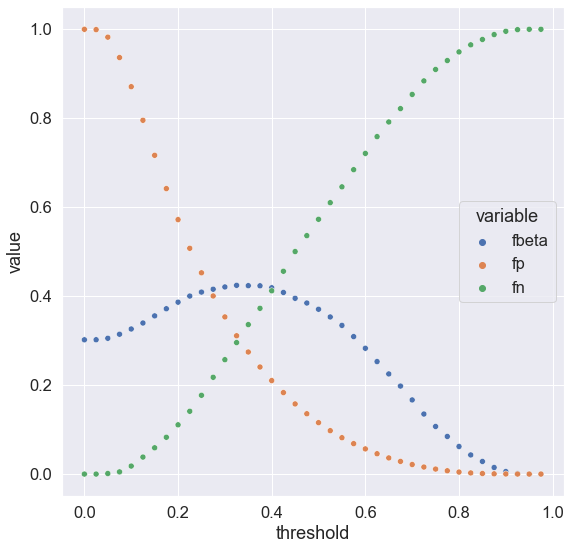

In [225]:
def fp_fn_fbeta(model, x_, y_, beta = 2):
    thresh = np.arange(0,1,0.025)
    pp_ = model.predict_proba(x_)[:,1]
    tots = np.array([dict(Counter(y_))[0], dict(Counter(y_))[1]])

    output = []

    for t in thresh:
        yp_ = (pp_ > t).astype('int')
        fbeta = fbeta_score(y_, yp_, beta = beta)
        cm = confusion_matrix(y_, yp_) / tots[:,None]
        fp_ = cm[0,1]
        fn_ = cm[1,0]
        output.append([t, fbeta, fp_, fn_])
    
    return pd.melt(pd.DataFrame(output, columns = ['threshold', 'fbeta', 'fp', 'fn']), id_vars='threshold')

dtfp_xgb = fp_fn_fbeta(cls_xgb, X_valid, y_valid, beta = 2)

sns.set(rc = {'figure.figsize':(9,9)}, font_scale = 1.5)
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=dtfp_xgb, x = 'threshold', y = 'value', hue = 'variable')


## Global features importance

<AxesSubplot:xlabel='imp', ylabel='feats'>

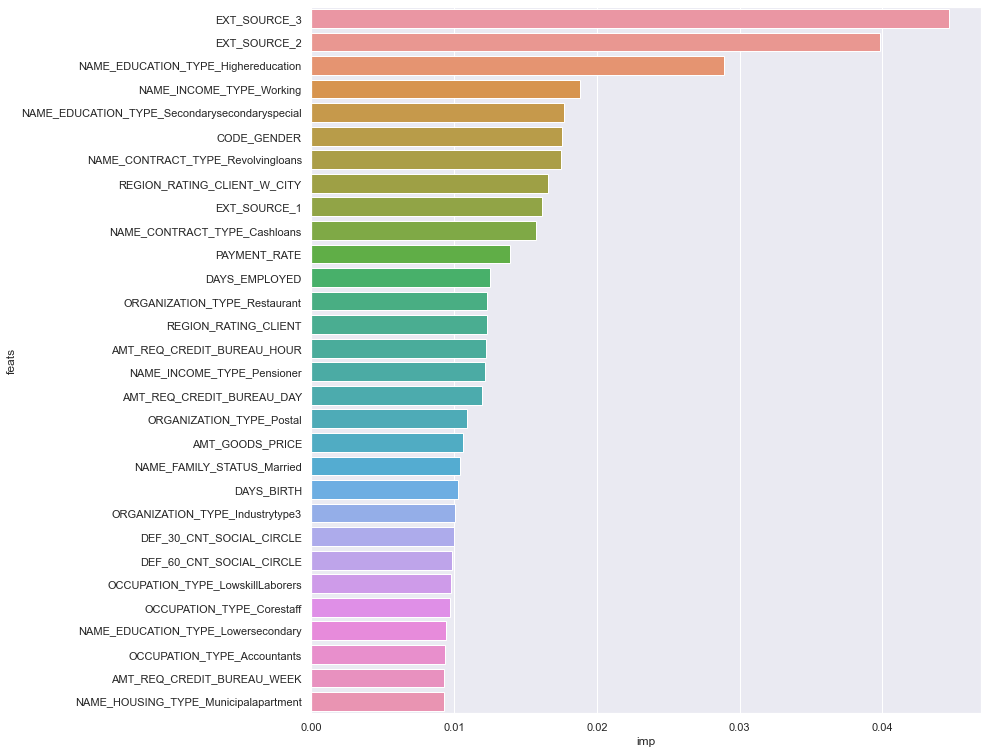

In [226]:
features_imp_xgb = pd.DataFrame( {'feats' : cls_xgb.feature_names_in_,
               'imp' : cls_xgb.feature_importances_}).sort_values('imp', ascending=False).iloc[:30,:]


sns.set(rc = {'figure.figsize':(12,13)}, font_scale = 1.)
sns.barplot(y = 'feats', x = 'imp', data = features_imp_xgb)


## Local features importance (using SHAP - LIME is not appropriate for one-hot encoding)

In [335]:
import shap 

max_shap = 150000

xgb_explainer = shap.TreeExplainer(cls_xgb)
shap_values = xgb_explainer(app_ss.drop(columns=['SK_ID_CURR']).iloc[:max_shap,:])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [336]:
with open('shap_xgb_explainer.pkl', 'wb') as outp:
    pickle.dump(xgb_explainer, outp, pickle.HIGHEST_PROTOCOL)

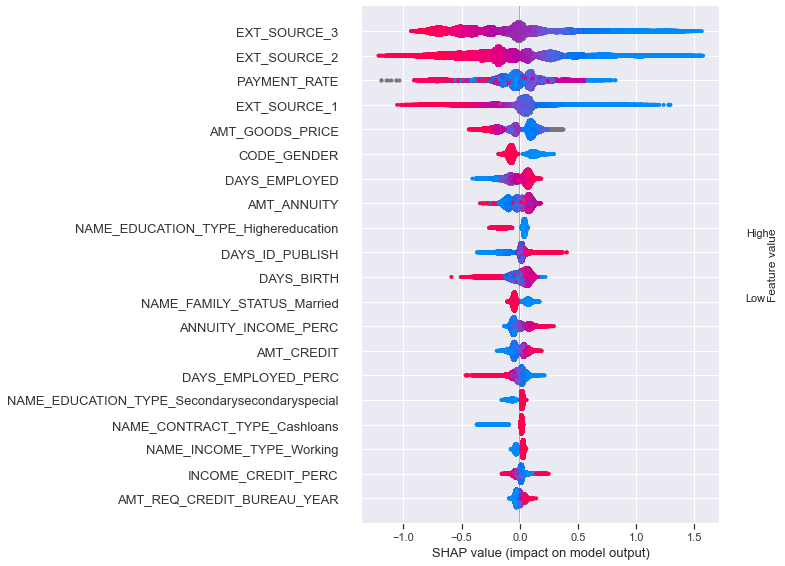

In [337]:
shap.summary_plot(shap_values)

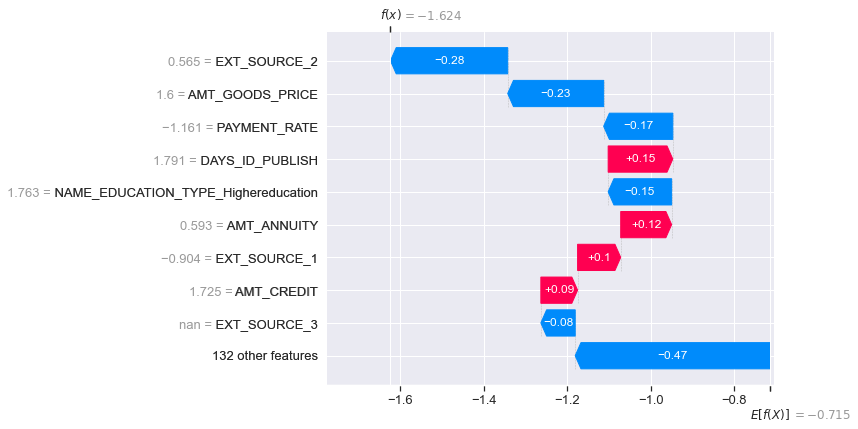

In [370]:
shap.waterfall_plot(shap_values[1], )

## Reaggregate Categorical features

In [360]:
import copy

shap_values_df = pd.DataFrame(shap_values.values, columns = shap_values.feature_names)
shap_values_agg = copy.copy(shap_values)

In [361]:
# Get cumulated shap values
for cc in cat_cols:
    sumc = np.zeros( shap_values_df.shape[0] )
    for c in [x for x in shap_values_df.columns if cc in x]:
        sumc = sumc + shap_values_df.pop(c)
    shap_values_df[cc] = sumc
    
shap_values_agg.values = np.array(shap_values_df)

In [365]:
# Rebuild associated data
tmp_df = app_ss.drop(columns=['SK_ID_CURR']).iloc[:max_shap,:]

new_data = pd.DataFrame()
for c in shap_values_df.columns:
    if c in cat_cols:
        new_data[c] = application[c]
    else:
        new_data[c] = tmp_df[c]

shap_values_agg.data = np.array(new_data)

shap_values_agg.feature_names = list(new_data.columns)

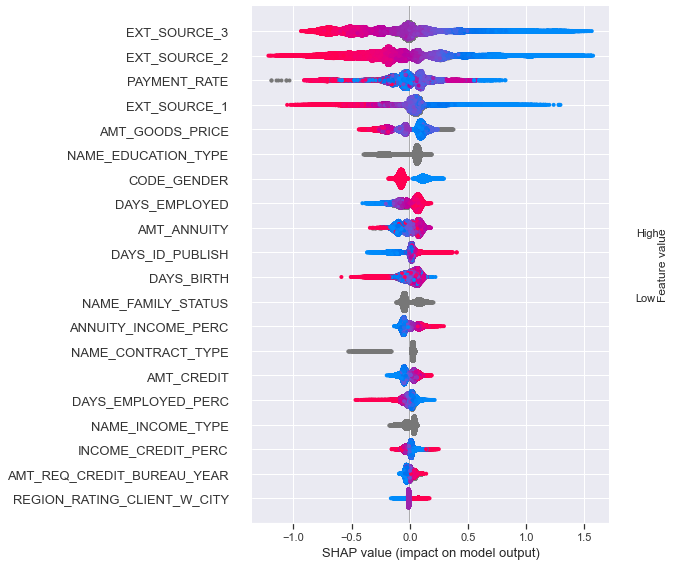

In [366]:
shap.summary_plot(shap_values_agg)

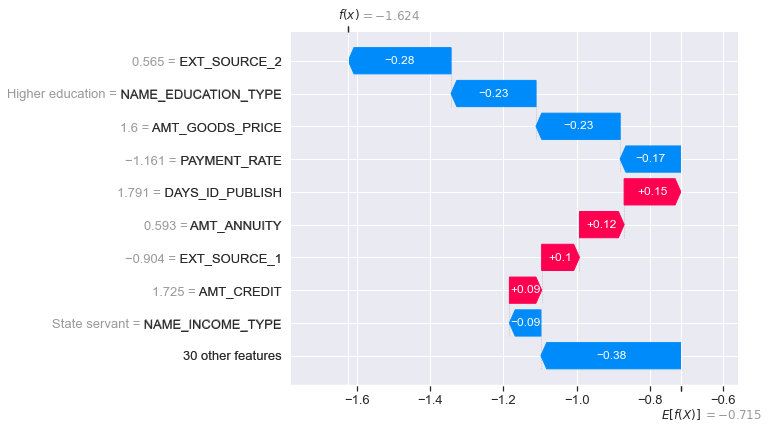

In [369]:
shap.waterfall_plot(shap_values_agg[1], )